# Оценка эффекта с помощью Лассо и бутстрапа

In [2]:
import sklearn
from scipy.stats import bootstrap as boot
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set_theme()

### Чистим данные от пропусков, случайные города из контрольной группы назначаем плацебо

In [3]:
df = pd.read_csv('C:/Users/unstr/Documents/6 семестр работы/Отрынки/mortgage_project_2024/arctic1009.csv')
df = df.rename(columns = {'date': 'month_dt'})
df

,city,population,p_avg_per_m_sec,month_dt,t,dummy_space,dummy_time,reg_russian,federal_district,lat,lon,city_id,city_rk
0,Барнаул,630877,81073.0,2022-01-01,1,0,0,Алтайский край,Сибирский,53.347361,83.77833,184,Барнаул_Алтайский край
1,Нижнеудинск,29995,52594.0,2022-01-01,1,0,0,Иркутская область,Сибирский,54.900000,99.01667,820,Нижнеудинск_Иркутская область
2,Верхняя Пышма,71335,77425.0,2022-01-01,1,0,0,Свердловская область,Уральский,56.966670,60.58333,152,Верхняя Пышма_Свердловская область
3,Бирюсинск,8632,53207.0,2022-01-01,1,0,0,Иркутская область,Сибирский,55.950000,97.81667,150,Бирюсинск_Иркутская область
4,Арамиль,19013,68613.0,2022-01-01,1,0,0,Свердловская область,Уральский,56.700000,60.83333,793,Арамиль_Свердловская область
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27542,Ипатово,26122,54183.0,2024-08-01,32,0,1,Ставропольский край,Северо-Кавказский,45.716670,42.90000,272,Ипатово_Ставропольский край
27543,Белая Холуница,9659,15444.0,2024-08-01,32,0,1,Кировская область,Приволжский,58.833330,50.85000,326,Белая Холуница_Кировская область
27544,Беломорск,7708,42477.0,2024-08-01,32,1,1,Республика Карелия,Северо-Западный,64.516670,34.76667,887,Беломорск_Республика Карелия
27545,Пудож,7356,44961.0,2024-08-01,32,0,1,Республика Карелия,Северо-Западный,61.800000,36.53333,811,Пудож_Республика Карелия


In [4]:
x = df[df['month_dt'] >= '2022-01-01']
x = pd.pivot_table(x, index = 'city_id', aggfunc="count").reset_index()

x = x[['city_id', 'city']].rename(columns = {'city': 'count'})
x

x1 = x[x['count'] == 32]
x1

#сколько было тритмента
treat = df.loc[df['dummy_space'] == 1, 'city_id']
treat = treat.drop_duplicates()
treat =  treat.to_list()
len(treat)

#сколько осталось тритмента
city_id = x1['city_id'].to_list()
df = df[df['city_id'].isin(city_id)]
len(df.loc[df['dummy_space'] == 1, 'city_id'].unique())

22

In [5]:
control_cities = list(set(list(df.query('dummy_space== 0')['city_id'])))
len(control_cities)

643

In [6]:
import random
random.seed(42)
group_of_items = control_cities  
num_to_select = len(df.loc[df['dummy_space'] == 1, 'city_id'].unique())                           
list_of_random_items = random.sample(group_of_items, num_to_select)
df['placebo_flg'] = df['city_id'].apply(lambda x: int(x in list_of_random_items))

C:\Users\unstr\AppData\Local\Temp\ipykernel_9728\2481415129.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['placebo_flg'] = df['city_id'].apply(lambda x: int(x in list_of_random_items))


In [22]:
#Создаю зависимую переменную в процентах к ноябрю 2023 года
tmp = df.query('month_dt == "2023-11-01"')
price_dict = {tmp['city_id'].iloc[i] :tmp['p_avg_per_m_sec'].iloc[i] for i in range(len(tmp))}
df['price_scaled'] = df['p_avg_per_m_sec']/df['city_id'].apply(lambda x: price_dict[x])

C:\Users\unstr\AppData\Local\Temp\ipykernel_9728\1171919576.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_scaled'] = df['p_avg_per_m_sec']/df['city_id'].apply(lambda x: price_dict[x])


### График, как росли во времени цены в городах воздействия относительно всех других городов --- на нём это плохо видно, но он красивый

In [59]:
pic1 = df.query('dummy_space == 1').pivot(columns='city_rk', index='month_dt', values='p_avg_per_m_sec').reset_index()
pic0 = df.query('dummy_space == 0').pivot(columns='city_rk', index='month_dt', values='p_avg_per_m_sec').reset_index()

In [68]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
fig = go.Figure()
for city in pic0.columns.to_list()[1:]:
    fig.add_trace(go.Scatter(x=pic0['month_dt'], y=np.log(pic0[city]),
                    mode='lines',
                    name=city
                    , opacity = 0.1
                    , line = dict(color = 'grey')))
for city in pic1.columns.to_list()[1:]:
    fig.add_trace(go.Scatter(x=pic1['month_dt'], y=np.log(pic1[city]),
                    mode='lines',
                    name=city
                    , opacity = 0.8
                    # , line = dict(color = 'red')
                    ))
fig.write_html('log_price_in_time.html')
fig.show()


### Внутри бутстрапа сэмплируем по городам --- 1000 итераций

In [24]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from datetime import datetime

def synth_ci_new(df
    , alpha:float
    , id_name = 'city_id' 
    , t_name = 'month_dt'
    , dummy_space_name = 'dummy_space' 
    , t_treatment = '2023-12-01'
    , y_name = 'p_avg_per_m_sec'
    , trend = False
    , placebo = False
    , dummies = True
    ):
    
    df['city_id'] = df['city_id'].astype(str)


    def sc(city_id_list:list):
        '''Функция, которая принимает на вход DataFrame с id городов 
        и выдаёт временной ряд среднего эффекта воздействия'''
        #Проставляем флаги тритмента и плацебо
        sub_df = df[df[id_name].apply(lambda x: x in city_id_list)]
        treatment_cities = list(set(list(sub_df.query(dummy_space_name+'== 1')[id_name])))
        placebo_cities = list(set(list(sub_df.query('placebo_flg == 1')[id_name])))
        tmps =[]
        if not placebo:
            cities_list = treatment_cities
        else:
            cities_list = placebo_cities

        #Идём по городам воздействия/плацебо
        if len(cities_list) == 0:
            return np.nan
        for city in cities_list:
            #Берём один город плацебо|воздействия и все контрольные
            tmp = sub_df[(sub_df[id_name] == city) | (sub_df[dummy_space_name] == 0) & (sub_df['placebo_flg'] == 0)]
            #Вытягиваем в столбик: цена в городе city цены в тот же период в городах контрольной группы
            tmp = tmp.pivot(index = t_name, columns = id_name, values = y_name).reset_index()
            #Добавляем фиксированные эффекты
            tmp['tr_city_id'] = city
            tmp['tr_city'] = tmp[city] #Зависимая переменная 
            tmp.drop(columns = city, inplace = True)
            tmps += [tmp]        
        #Конкатенируем всё в один датафрейм
        tmp = pd.concat(tmps)
        
        if trend:
            #Разница в датах считается в днях, потому что по-другому я не смог
            tmp['t'] = tmp[t_name].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))-datetime.strptime('2022-04-01', '%Y-%m-%d')
            tmp['t'] = tmp['t'].apply(lambda x: abs(x).days)

        if dummies:
            #Делаю фиксированные эффекты городов воздействия/плацебо 
            enc = OneHotEncoder(sparse_output=False, drop='first')
            enc_transformed = enc.fit_transform(tmp[['tr_city_id']])
            enc_df = pd.DataFrame(columns=enc.get_feature_names_out(), data=enc_transformed)
            tmp = pd.concat([tmp.reset_index(drop=True), enc_df.reset_index(drop=True)], axis=1)

        tmp.drop(columns = 'tr_city_id', inplace=True)        

        #Обучаем регрессор на претренде
        train = tmp.loc[tmp[t_name] < t_treatment]
        #Не забываем отшкалировать переменные, чтобы корректино предсказывать 
        scaler = StandardScaler()
        lr = Lasso(alpha=alpha)
        lr.fit(scaler.fit_transform(train.drop(columns = ['tr_city', t_name])), train['tr_city'])
            #Записываем в результат разницу между истинным значением и предиктом
        res = pd.DataFrame({'y_true':tmp['tr_city'], 'y_predict': lr.predict(scaler.transform(tmp.drop(columns = ['tr_city', t_name])))
                            , t_name:tmp[t_name]}).groupby(t_name, as_index=False).agg('mean')
        return res
    
    cities_list = list(set(list(df[id_name])))

    #Оценка по всему датафрейму
    res1 = sc(cities_list)
    
    #Доверительные интервалы считаем через бутстрап
    def boot_sc(df):
        tmp = sc(df)
        return tmp['y_true'] -tmp['y_predict'] 
    b = boot((cities_list,), boot_sc, n_resamples=1000, method = 'basic')

    res1['lower'] = b.confidence_interval.low
    res1['upper'] = b.confidence_interval.high

    return res1

C:\Users\unstr\AppData\Local\Temp\ipykernel_8484\580091472.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['city_id'] = df['city_id'].astype(str)


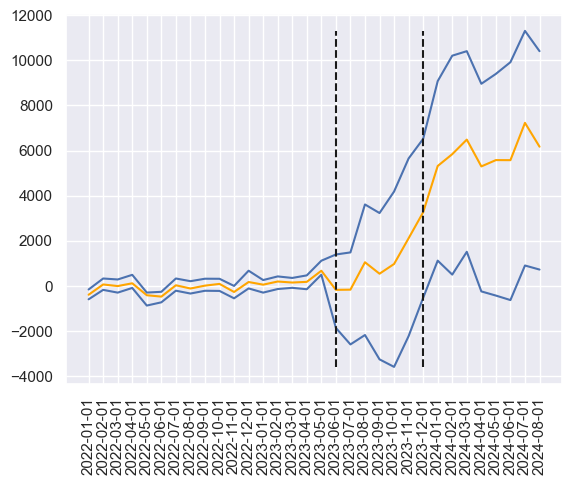

In [17]:
t_treatment= '2023-06-01'
data = synth_ci_new(df, 2e2, t_treatment= t_treatment, trend=True, dummies=True)
data['diff'] = data['y_true'] - data['y_predict']
plt.plot(data['month_dt'], data['diff'], color = 'orange')
plt.xticks(rotation =90)
plt.plot(data['month_dt'], data['upper'], color = 'b')
plt.plot(data['month_dt'], data['lower'], color = 'b')
plt.vlines(x = ['2023-12-01', t_treatment], ymin = data['lower'].min(), ymax = data['upper'].max(), colors='k', linestyles='--')

C:\Users\unstr\AppData\Local\Temp\ipykernel_8484\580091472.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['city_id'] = df['city_id'].astype(str)


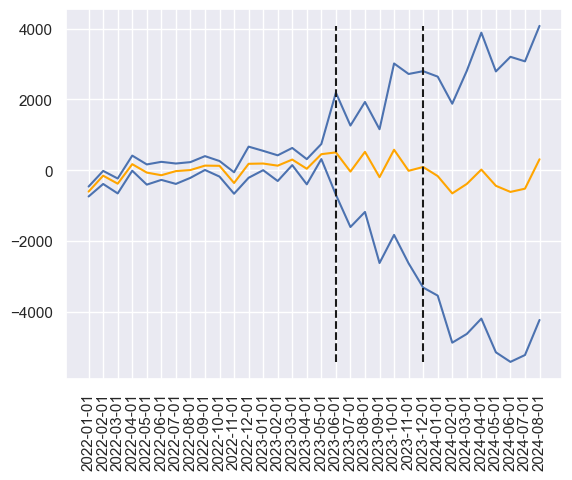

In [16]:
#Плацебо тест на претренде
t_treatment= '2023-06-01'
data = synth_ci_new(df, 2e2, t_treatment= t_treatment, trend=True, placebo = True, dummies = True)
data['diff'] = data['y_true'] - data['y_predict']
plt.plot(data['month_dt'], data['diff'], color = 'orange')
plt.xticks(rotation =90)
plt.plot(data['month_dt'], data['upper'], color = 'b')
plt.plot(data['month_dt'], data['lower'], color = 'b')
plt.vlines(x = ['2023-12-01', t_treatment], ymin = data['lower'].min(), ymax = data['upper'].max(), colors='k', linestyles='--')


### Используем шкалированную зависимую переменную 

C:\Users\unstr\AppData\Local\Temp\ipykernel_9728\3561519146.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['city_id'] = df['city_id'].astype(str)
c:\Users\unstr\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.244e-04, tolerance: 4.437e-04
  model = cd_fast.enet_coordinate_descent(
c:\Users\unstr\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the feature

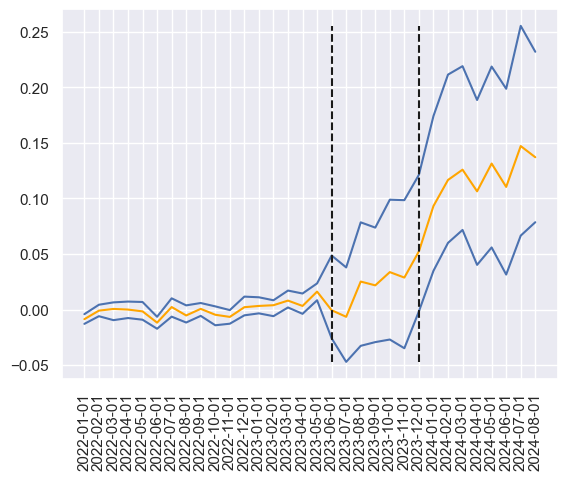

In [33]:
t_treatment= '2023-06-01'
data = synth_ci_new(df, 0.005, t_treatment= t_treatment, trend=True, dummies=True
                    , y_name = 'price_scaled')
data['diff'] = data['y_true'] - data['y_predict']
plt.plot(data['month_dt'], data['diff'], color = 'orange')
plt.xticks(rotation =90)
plt.plot(data['month_dt'], data['upper'], color = 'b')
plt.plot(data['month_dt'], data['lower'], color = 'b')
plt.vlines(x = ['2023-12-01', t_treatment], ymin = data['lower'].min(), ymax = data['upper'].max(), colors='k', linestyles='--')

C:\Users\unstr\AppData\Local\Temp\ipykernel_9728\3561519146.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['city_id'] = df['city_id'].astype(str)
c:\Users\unstr\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.675e-04, tolerance: 3.492e-04
  model = cd_fast.enet_coordinate_descent(


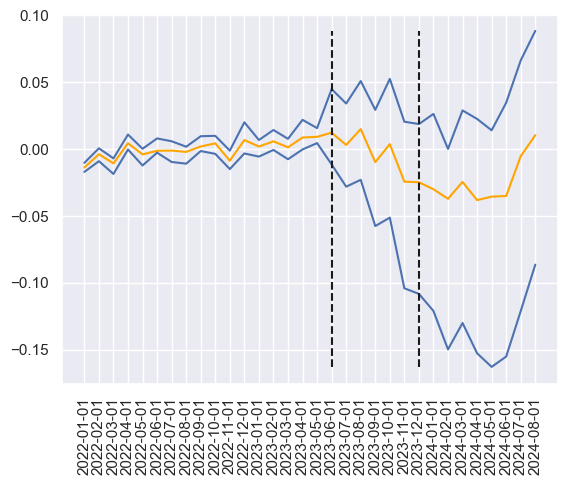

In [32]:
#Плацебо тест на претренде
t_treatment= '2023-06-01'
data = synth_ci_new(df, 0.005, t_treatment= t_treatment, trend=True, placebo = True, dummies = True
                    , y_name = 'price_scaled')
data['diff'] = data['y_true'] - data['y_predict']
plt.plot(data['month_dt'], data['diff'], color = 'orange')
plt.xticks(rotation =90)
plt.plot(data['month_dt'], data['upper'], color = 'b')
plt.plot(data['month_dt'], data['lower'], color = 'b')
plt.vlines(x = ['2023-12-01', t_treatment], ymin = data['lower'].min(), ymax = data['upper'].max(), colors='k', linestyles='--')
